Generate encoded vectors for both query and artist aggregrate images

In [18]:
import dataset
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa 

import matplotlib.pylab as plt
import matplotlib as mpl
MIN_NUM_ARTWORK = 500


In [19]:
# LOAD IMAGE AND LABELS HERE
# replace for your path here!
img_folder = '/Users/erebor/Downloads/out_img'

images, labels_onehot, labels, names, = dataset.load_data(MIN_NUM_ARTWORK=MIN_NUM_ARTWORK,
                                                 img_folder = img_folder,
                                                 labels_file ='labels.txt',
                                                 names_file = 'names.txt')

 [███████████████████████████████████████-] 112038/112039 

Dataset loaded!

images shape:	  (19007, 56, 56, 3)
labels shape:	  (19007,)
labels (one-hot): (19007, 21)
names shape:	  (19007, 1)

              # of unique artists: 21
Min # of artworks for all artists: 517
      Min # of artworks specified: 500


In [20]:
classes = len(list(set(labels)))
print('\n# of unique artists:',classes)

counts = pd.DataFrame(labels).value_counts()
print('Min # of artworks for all artists:',min(counts))
print('Min # of artworks specified:',MIN_NUM_ARTWORK)


# of unique artists: 21
Min # of artworks for all artists: 517
Min # of artworks specified: 500


In [21]:
# LOAD PRE-TRAINED ENCODER
# get base pre-trained model first
# more models are available here: https://www.tensorflow.org/api_docs/python/tf/keras/applications

# define hyperparameters
# define image size 
input_shape = (56,56,3)
D = 50
# define number of classes
# ****THIS sets the number of dimensions of the encoded vector ("D") in Mark's email***
# we'll probably want adjust this to be smaller or larger (depending on training results)
# for now, classes are just the number of unique artist
base_kwargs = {'include_top':False,
               'weights':'imagenet',
               'input_shape':input_shape,
               'pooling':None,
               'classes':D}
#enet_base = tf.keras.applications.efficientnet.EfficientNetB7(**enet_kwargs)
base = tf.keras.applications.vgg19.VGG19(**base_kwargs)

# set that the encoder DOES NOT train on the images
base.trainable = True

# set pre-trained model as base
encoder = tf.keras.models.Sequential()
encoder.add(base)

# add two final top layers
#encoder.add(tf.keras.layers.GlobalMaxPooling2D())
encoder.add(tf.keras.layers.GlobalMaxPooling2D())
#encoder.add(tf.keras.layers.Dropout(rate=0.01))

encoder.add(tf.keras.layers.Dense(D, activation="sigmoid")) # last (top) layer of network

In [22]:
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                25650     
Total params: 20,050,034
Trainable params: 20,050,034
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Create encoded tensors for all 
vectors = encoder.predict(images,verbose=1)

594/594 [==============================] - 118s 198ms/step


In [24]:
vectors

array([[1.6964210e-11, 5.4149419e-02, 9.9834716e-01, ..., 9.9824560e-01,
        8.9147371e-01, 2.2481710e-07],
       [1.5931160e-07, 2.2711192e-05, 9.9886876e-01, ..., 9.9999976e-01,
        3.3871728e-11, 4.3399334e-03],
       [2.6576444e-07, 9.9861467e-01, 1.0000000e+00, ..., 2.5894658e-05,
        1.7151082e-01, 1.9982281e-11],
       ...,
       [2.8627749e-09, 5.6641597e-01, 1.0000000e+00, ..., 6.9439658e-09,
        7.5203896e-02, 3.0178191e-07],
       [9.9824727e-01, 3.5645574e-02, 9.1546047e-01, ..., 2.6139921e-07,
        9.9957013e-01, 2.1629971e-17],
       [2.0819902e-03, 1.0738485e-04, 1.0000000e+00, ..., 2.7415156e-04,
        5.9361682e-06, 2.0909012e-14]], dtype=float32)

In [25]:
def plot_images(images,artistname):

    # plot a selection of 25 (5x5) artwork
    fig, axes = plt.subplots(figsize=(10,10),nrows=5,ncols=5)
    fig.patch.set_facecolor('white')

    i = 0 
    for ax in axes.reshape(-1): 
        ax.imshow(images[i,:,:,:])
        ax.set_xticks([]),ax.set_yticks([])
        i +=1
    plt.suptitle('Artist: {}'.format(artistname),fontsize=15)
    fig.subplots_adjust(top=0.9)
    plt.savefig('figs/samples/artist_{}.png'.format(artistname[0].replace(',','-').replace(' ','-')),dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()

In [26]:
def get_aggregrate_vectors(vectors,labels):
    # Create aggregate vectors
    # Count how many pieces each artist has
    total_bc = np.bincount(labels) # get count of artists
    artcounts = total_bc[np.unique(labels)] # get count of artworks for each unique artist
    artistnames = names[np.unique(labels)] # get the name for each unique artist

    aggregate_vectors = []
    for i in range(len(artcounts)):
        artistnum = np.unique(labels)[i] #Gets the number that represents this artist from labels
        artistname = artistnames[i]
        artcount = artcounts[i] #Gets number of art pieces by this artist

        neg_idx = np.where(labels != artistnum) 
        pos_idx = np.where(labels == artistnum)
        artist_vector = np.mean(vectors[pos_idx],axis=0)

        query_images = images[neg_idx]
        query_vectors = vectors[neg_idx]

        aggregate_vectors.append(artist_vector)

        #x = np.expand_dims(vectors[pos_idx].T,axis=2)
        #artist_vector = pool_layer(x).numpy()
        #aggregate_vectors.append(artist_vector.reshape(50,))
    aggregate_vectors = np.array(aggregate_vectors)
    
    return aggregate_vectors, artistnames

In [27]:
def plot_aggregates(aggregate_vectors,artistnames,n=3):
    idx = list(range(aggregate_vectors.shape[0]))
    idxs = np.random.choice(a=idx,size=n*n)
    vectors = aggregate_vectors[idxs]
    artists = artistnames[idxs]
    
    fig, axes = plt.subplots(nrows=n,ncols=n,figsize=(9,5))
    for ax_idx, ax in enumerate(fig.axes):
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        ax.imshow(np.atleast_2d(vectors[ax_idx]), aspect=7, cmap='rainbow', interpolation=None,norm=norm)
        ax.set_xticks([]),ax.set_yticks([])
        ax.set_xlabel(artists[ax_idx][0])
    plt.savefig('figs/aggregrates_sample_trained.png',dpi=200,tight_layout=True)
    plt.show()
    plt.close()

In [28]:
def plot_aggregate_dist(aggregate_vectors):
    plt.figure()
    bins = np.arange(0,1.1,0.05)
    for vector in aggregate_vectors:
        plt.hist(vector,bins=bins,alpha=0.25,histtype='bar')
    plt.xlim(-0.05,1.05)
    plt.show()
    plt.title('Aggregrate Vectors')
    plt.close()

<ipython-input-27-4c977d2a8d23>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figs/aggregrates_sample_trained.png',dpi=200,tight_layout=True)


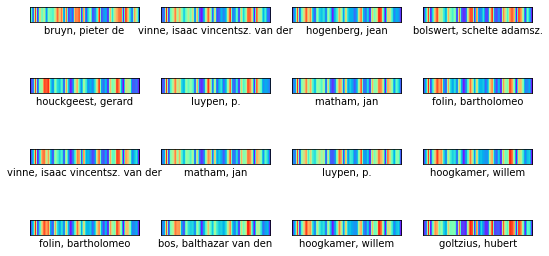

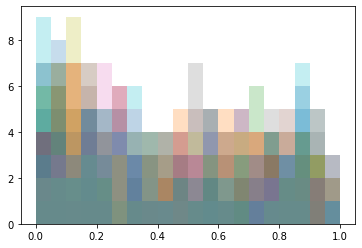

In [29]:
aggregate_vectors, artistnames = get_aggregrate_vectors(vectors=vectors,labels=labels)
plot_aggregates(aggregate_vectors,artistnames,n=4)
plot_aggregate_dist(aggregate_vectors)

In [51]:
# Query Image Removal Function
def query_image_remover(query_vector, aggregate_vector, artcount):
    new_aggregate_vector = (aggregate_vector - (query_vector * (1/artcount))) * (artcount/(artcount-1))
    return new_aggregate_vector

In [52]:
print(vectors)

[[1.6964210e-11 5.4149419e-02 9.9834716e-01 ... 9.9824560e-01
  8.9147371e-01 2.2481710e-07]
 [1.5931160e-07 2.2711192e-05 9.9886876e-01 ... 9.9999976e-01
  3.3871728e-11 4.3399334e-03]
 [2.6576444e-07 9.9861467e-01 1.0000000e+00 ... 2.5894658e-05
  1.7151082e-01 1.9982281e-11]
 ...
 [2.8627749e-09 5.6641597e-01 1.0000000e+00 ... 6.9439658e-09
  7.5203896e-02 3.0178191e-07]
 [9.9824727e-01 3.5645574e-02 9.1546047e-01 ... 2.6139921e-07
  9.9957013e-01 2.1629971e-17]
 [2.0819902e-03 1.0738485e-04 1.0000000e+00 ... 2.7415156e-04
  5.9361682e-06 2.0909012e-14]]


In [53]:
artcounts

array([ 592,  534,  517, 1013,  649, 1267,  838,  893,  810,  640, 1119,
       1148,  560, 1928,  550, 1003,  856, 1504, 1384,  579,  623])

In [54]:
NUM_EXAMPLE = 20
train_val_split=0.8
dev_split = 0.1

total_bc = np.bincount(labels) # get count of artists
artcounts = total_bc[np.unique(labels)] # get count of artworks for each unique artist
artistnames = names[np.unique(labels)] # get the name for each unique artist

aggregate_vectors = []
artistnums = []
# iterate through each artist
for i in range(len(artcounts)):
    artistnum = np.unique(labels)[i] # Gets the number that represents this artist from labels
    artistnums.append(artistnum)
    
    artistname = artistnames[i] # Gets artist name as string
    artcount = artcounts[i] # Gets number of art pieces by this artist

    # get indicies of artist's artwork
    pos_idx = np.where(labels == artistnum)

    aggregate_vector = np.mean(vectors[pos_idx],axis=0)

    # store aggregrate vectors for each artist
    aggregate_vectors.append(aggregate_vector)


aggregate_vectors = np.array(aggregate_vectors)

# Generate pairs
total_pairs = np.zeros(shape=(len(labels)*2,2))
total_labels = np.zeros(shape=(len(labels)*2,1))

j = 0
total_artcounts = []
for i in range(len(artcounts)):
    artistnum = np.unique(labels)[i]
    artcount = artcounts[i]

    #Retreiving negative and positive indices
    pos_idx = np.where(labels == artistnum)[0]
    neg_idx = np.where(labels != artistnum)[0]


    #Adding Positive Pairs for a given artist
    for idx in pos_idx:
        #print('j:',j)
        #print('total pairs:', total_pairs)
        #print('idx:',idx)
        #print('artistnum:',artistnum)
        total_pairs[j,:] = [idx,artistnum]
        total_labels[j] = 1
        j = j + 1
        total_artcounts.append(artcounts[i])

    #Adding Negative Pairs for a given artist
    neg_selec = np.random.choice(neg_idx,artcount,replace=False)
    for idx in neg_selec:
        total_pairs[j,:] = [idx,artistnum]
        total_labels[j] = 0
        j = j + 1
        total_artcounts.append(artcounts[i])

# Create and Test Split Order
goodbalance = False
spltest_labels = total_pairs[:,1]

while goodbalance == False:

    #Shuffle data
    mixer = np.arange(len(total_pairs[:,1]))
    np.random.shuffle(mixer)
    total_pairs = total_pairs[mixer,:]
    total_labels = total_labels[mixer]

    #Make Cutoffs
    train_cutoff = int(len(total_pairs) * train_val_split)
    dev_cutoff = int(len(total_pairs) * (train_val_split + dev_split))

    #Test Splits for Balance
    spltest_labels = np.array(spltest_labels[mixer]).astype(int)
    train_spltest = spltest_labels[:train_cutoff]
    dev_spltest = spltest_labels[train_cutoff:dev_cutoff]
    val_spltest = spltest_labels[dev_cutoff:]

    total_bc_l = np.bincount(spltest_labels)
    train_bc = np.bincount(train_spltest)
    dev_bc = np.bincount(dev_spltest)
    val_bc = np.bincount(val_spltest)

    check_bool = np.array([],dtype=bool)

    for i in np.unique(labels):
        if (len(np.unique(spltest_labels)) == len(np.unique(train_spltest))) and (len(np.unique(spltest_labels)) == len(np.unique(dev_spltest))) and (len(np.unique(spltest_labels)) == len(np.unique(train_spltest))):
            train_check = abs(total_bc_l[i]*0.8 - train_bc[i]) >= total_bc_l[i]*0.2 
            dev_check = abs(total_bc_l[i]*0.1 - dev_bc[i]) >= total_bc_l[i]*0.08
            val_check = abs(total_bc_l[i]*0.1 - val_bc[i]) >= total_bc_l[i]*0.08 
            check_bool = np.append(check_bool,(train_check or dev_check or val_check))

        elif total_bc_l[i] != 0:
            check_bool = np.append(check_bool,False)

    if sum(check_bool) <= 0:
        goodbalance = True

# Turn Pairs of Indices into Pairs of Vectors
final_pairs = []
for i, total_pair in enumerate(total_pairs):
    
    # get query vector index
    vector_idx = int(total_pair[0])
    
    # get aggregrate index  
    aggregrate_idx = np.where(artistnums==total_pair[-1])[0][0]
    
    # get vectors
    aggregrate_vector = aggregate_vectors[aggregrate_idx]
    query_vector = vectors[vector_idx]

    # IF query image is a match and belongs to artist, subtract it from aggregrate vector
    if total_labels[i] == 1:
        remover_kwargs = {'query_vector':query_vector,
                         'aggregate_vector':aggregate_vector,
                         'artcount':total_artcounts[i]}
        aggregate_vector = query_image_remover(**remover_kwargs)
        
    # save to array
    final_pair = np.vstack([aggregrate_vector,query_vector]).T
    final_pairs.append(final_pair)

final_pairs = np.array(final_pairs)
print(final_pairs.shape)
# set aggregrate and query image pairs and labels into different
train_pairs = final_pairs[:train_cutoff,:,:]
train_labels = total_labels[:train_cutoff]

dev_pairs = final_pairs[train_cutoff:dev_cutoff,:,:]
dev_labels = total_labels[train_cutoff:dev_cutoff]

val_pairs = final_pairs[dev_cutoff:,:,:]
val_labels = total_labels[dev_cutoff:]


(38014, 50, 2)


In [33]:
spltest_labels

array([2193., 3718., 3718., ..., 5004., 2272., 3718.])

In [46]:
np.unique(labels)

array([ 631,  685,  912,  993, 1244, 1981, 2107, 2193, 2272, 2724, 2784,
       2819, 3537, 3718, 3849, 3981, 4682, 4766, 5004, 5247, 6217])

In [47]:
np.unique(total_pairs[:,1])

array([ 631.,  685.,  912.,  993., 1244., 1981., 2107., 2193., 2272.,
       2724., 2784., 2819., 3537., 3718., 3849., 3981., 4682., 4766.,
       5004., 5247., 6217.])

In [ ]:
total_pairs

array([[ 2730.,   912.],
       [ 9636.,  2193.],
       [16560.,  1981.],
       ...,
       [ 2214.,   912.],
       [ 6882.,  2272.],
       [ 4699.,  1244.]])

In [ ]:
def load_vectors(vectors, names, labels, NUM_EXAMPLE = 20, train_val_split=0.8, dev_split = 0.1):
    """
    purpose: load dataset of query and aggregrate vector pairs and binary label indicating same artist among the pair
        - label for each pair should be 1 if query vector and aggregrate vector belong to same artist, 0 if not
        - any query vector that DOES belong to the artist should be subracted from aggregrate vector
        - train, development, and validation are exclusive (no query image appear more than once)

    arguments: 
        vectors (numpy matrix)    : all vectors that were encoded from images of original dataset
        names  (list of strings)  : string for name of artist
        labels (list of integers) : integer index of artist
        NUM_EXAMPLE (integer)     : number of positive and negative pairs to create 
                                    e.g. total number of examples per artist is 2 * NUM_EXAMPLE
                                    NUM_EXAMPLE should NOT be g
    
    returns:
        train_pairs  : (batch, vector_length, 2) aggregrate and query image pairs for training
        train_labels : (batch, )                 labels (0 or 1) indicating artist match for training
        dev_pairs    : (batch, vector_length, 2) aggregrate and query image pairs for development
        dev_labels   : (batch, )                 labels (0 or 1) indicating artist match for development
        val_pairs    : (batch, vector_length, 2) aggregrate and query image pairs for validation
        val_labels   : (batch, )                 labels (0 or 1) indicating artist match for validation
    """
    total_bc = np.bincount(labels) # get count of artists
    artcounts = total_bc[np.unique(labels)] # get count of artworks for each unique artist
    artistnames = names[np.unique(labels)] # get the name for each unique artist
    
    aggregate_vectors = []
    # iterate through each artist
    for i in range(len(artcounts)):
        artistnum = np.unique(labels)[i] # Gets the number that represents this artist from labels
        artistname = artistnames[i] # Gets artist name as string
        artcount = artcounts[i] # Gets number of art pieces by this artist

        # get indicies of artist's artwork
        pos_idx = np.where(labels == artistnum)
               
        aggregate_vector = np.mean(vectors[pos_idx],axis=0)
        
        # store aggregrate vectors for each artist
        aggregate_vectors.append(aggregate_vector)

    aggregate_vectors = np.array(aggregate_vectors)

    # Generate pairs
    total_pairs = np.zeros(shape=(len(labels)*2,2))
    total_labels = np.zeros(shape=(len(labels)*2,1))
    
    j = 0
    for i in range(len(artcounts)):
        artistnum = np.unique(labels)[i]
        artcount = artcounts[i]

        #Retreiving negative and positive indices
        pos_idx = np.where(labels == artistnum)[0]
        neg_idx = np.where(labels != artistnum)[0]

        #Adding Positive Pairs for a given artist
        for idx in pos_idx:
            #print('j:',j)
            #print('total pairs:', total_pairs)
            #print('idx:',idx)
            #print('artistnum:',artistnum)
            total_pairs[j,:] = [idx,artistnum]
            total_labels[j] = 1
            j = j + 1

        
        #Adding Negative Pairs for a given artist
        neg_selec = np.random.choice(neg_idx,artcount,replace=False)
        for idx in neg_selec:
            total_pairs[j,:] = [idx,artistnum]
            total_labels[j] = 0
            j = j + 1

    # Create and Test Split Order
    goodbalance = False
    spltest_labels = total_pairs[:,1]

    while goodbalance == False:

        #Shuffle data
        mixer = np.arange(len(total_pairs[:,1]))
        np.random.shuffle(mixer)
        total_pairs = total_pairs[mixer,:]
        total_labels = total_labels[mixer]

        #Make Cutoffs
        train_cutoff = int(len(total_pairs) * train_val_split)
        dev_cutoff = int(len(total_pairs) * (train_val_split + dev_split))

        #Test Splits for Balance
        spltest_labels = spltest_labels[mixer]
        train_spltest = spltest_labels[:train_cutoff]
        dev_spltest = spltest_labels[train_cutoff:dev_cutoff]
        val_spltest = spltest_labels[dev_cutoff:]

        total_bc_l = np.bincount(spltest_labels)
        train_bc = np.bincount(train_spltest)
        dev_bc = np.bincount(dev_spltest)
        val_bc = np.bincount(val_spltest)

        check_bool = np.array([],dtype=bool)

        for i in np.unique(labels):
            if (len(np.unique(spltest_labels)) == len(np.unique(train_spltest))) and (len(np.unique(spltest_labels)) == len(np.unique(dev_spltest))) and (len(np.unique(spltest_labels)) == len(np.unique(train_spltest))):
                train_check = abs(total_bc_l[i]*0.8 - train_bc[i]) >= total_bc_l[i]*0.2 
                dev_check = abs(total_bc_l[i]*0.1 - dev_bc[i]) >= total_bc_l[i]*0.08
                val_check = abs(total_bc_l[i]*0.1 - val_bc[i]) >= total_bc_l[i]*0.08 
                check_bool = np.append(check_bool,(train_check or dev_check or val_check))

            elif total_bc_l[i] != 0:
                check_bool = np.append(check_bool,False)

        if sum(check_bool) <= 0:
            goodbalance = True


    # Turn Pairs of Indices into Pairs of Vectors
    for i in range(len(labels)*2):

        k = np.where(np.unique(labels) == int(total_pairs[i,1]))[0]
        print('\nnp.unique(labels):\n',np.unique(labels))
        print('\nint(total_pairs[i,1]):', int(total_pairs[i,1]))
        print('\nnp.where(np.unique(labels) == int(total_pairs[i,1]))[0]:',np.where(np.unique(labels) == int(total_pairs[i,1]))[0])
        print('\nk:',k)
        print('\nnp.unique(total_pairs[:,1]):\t',np.unique(total_pairs[:,1]))
        total_pairs[i,:] = [vectors[int(total_pairs[i,0])],aggregate_vectors[int(total_pairs[k,1])]]

    # Split Pairs x
    train_pairs = total_pairs[:train_cutoff,:,:]
    train_labels = total_labels[:train_cutoff]

    dev_pairs = total_pairs[train_cutoff:dev_cutoff,:,:]
    dev_labels = total_labels[train_cutoff:dev_cutoff]

    val_pairs = total_pairs[dev_cutoff:,:,:]
    val_labels = total_labels[dev_cutoff:]

    return train_pairs, train_labels, dev_pairs, dev_labels, val_pairs, val_labels

In [ ]:
labels.

array([2272, 5004,  993, ..., 3718,  993, 2819])

In [ ]:
train_pairs, train_labels, dev_pairs, dev_labels, val_pairs, val_labels = \
    load_vectors(vectors=vectors, names=names, labels=labels, NUM_EXAMPLE = 20, train_val_split=0.8, dev_split = 0.1)


np.unique(labels):
 [ 631  685  912  993 1244 1981 2107 2193 2272 2724 2784 2819 3537 3718
 3849 3981 4682 4766 5004 5247 6217]

int(total_pairs[i,1]): 993

np.where(np.unique(labels) == int(total_pairs[i,1]))[0]: [3]

k: [3]

np.unique(total_pairs[:,1]):	 [ 631.  685.  912.  993. 1244. 1981. 2107. 2193. 2272. 2724. 2784. 2819.]


IndexError: index 2784 is out of bounds for axis 0 with size 21

In [1]:
import numpy as np

In [12]:
test = np.random.randint(1,9,5)
test2 = np.random.choice(test,3,replace=False)
for i in test2:
  print(i)

5
8
6
